# Who or What Extracts Keywords Better? 

In [1]:
# import dependencies 
import pandas as pd
import re
from deep_translator import GoogleTranslator
import yake
from multi_rake import Rake
from summa import keywords
from keybert import KeyBERT
import plotly.graph_objects as go
from wordcloud import WordCloud
from IPython.display import HTML
import matplotlib.pyplot as plt

#expand column width
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)


## Instructions
Each block of the practical assignment has discussion questions and required actions, as well as cells, where you can write answers for the questions

####  <span style="color:green">??? Questions are marked in green </span>
####  <span style="color:DarkRed">!!! Action needed: Required actions are marked in dark red</span>

 <figure>
<img src="./static/human-vs-robots.jpeg" style="width:100%">
<figcaption align = "center"> Image Credit: depositphotos.com </figcaption>
</figure>

## What will we do today?
**Intro**  \
What data are we using?\
Description of the dataset <br>
Data exploration <br>
**Part One** \
What are 🔑words? How do we find them? \
How long would that take?\
**Part Two** \
Extracting Keywords Computationally \
**Part Three** \
Comparing the results

## Architektenlexikon
Data of the publication by Isabelle Rucki, Dorothee Huber (eds). Architektenlexikon der Schweiz 19./20. Jahrhundert, Basel/Boston/Berlin 1998.

In [2]:
file_path = "./texts/architektenlexikon.txt"

## First some data exploration

Let's have a look at the text and try to find some structure within it. 
####  <span style="color:green">??? How are the entries separated from each other? What information do entries include? </span>

In [3]:
with open(file_path, "r") as f:
    text = ""
    for i, line in enumerate(f):
        if i >= 500:
            break
        text += line
    print(text)

Aberle, Anton
*14.11.1876 in Möhringen (D), 115.8.1953 in Thusis GR, Architekt.
Aufgewachsen im südlichen Schwarzwald, be- suchte der Bauernsohn nach einer Zimmermannslehre die Karlsruher Bauhochschule. Im Anschluß an sein Studium fand er 1904 eine Anstellung bei Curjel und Moser (Robert -► Curjel,
Karl -► Moser) in Karlsruhe und wurde mit der Bauleitung eines Hotels auf dem Feldberg im Schwarzwald beauftragt. 1906kam A als Bauleiter der Karlsruher Architekten nach St. Gallen.
Hier entstanden unter seiner Regie die bedeutenden Stickereigeschäftshäuser Pacific an der Schreinerstraße (1906/07, zugleich Geschäftssitz der St. Galler Zweigstelle von «Curjel und Moser» und Wilson an der Teufenerstraße (1907/08).
1909 machte sich A selbständig. Zwei Jahre später erhielt er das Bürgerrecht seiner Ostschweizer Wahlheimat und heiratete die Tochter eines Fensterfabrikanten. 1910-20 erstellte er verschiedene Geschäftshäuser und Stickereifabriken in der Stadt St. Gallen, in Amriswil und im vorarlbe

### Making text more human-readable, structuring text

We are going to use a type of data structure called <b>dataframe</b>. \
<b>Dataframe</b> is a data structure that organizes data into a 2-dimensional table of rows and columns, much like a spreadsheet. DataFrames are one of the most common data structures used in modern data analytics because they are a flexible and intuitive way of storing and working with data.

So, ultimately, <b>dataframe</b> is a huge table or a spreadsheet, which can be accessed computationally.


In [4]:
split_line ="############### ENTRY BOUNDARY ###############"

def create_entries(file_path, split_line):
    """
    Reads a text file and creates a Pandas DataFrame based on the split line.

    Parameters:
    file_path (str): The path to the text file.
    split_line (str): The split line to use for separating the text. 
    Returns:
    pd.DataFrame: The Pandas DataFrame containing the name and biography columns.
    """
    # Read the text file
    with open(file_path, "r") as f:
        text = f.read()

    # Split the text into entries based on the split line
    entries = text.split(split_line)

    # Create a list to hold the data
    data = []

    # Loop through each entry
    for entry in entries:
        # Split the entry into name and biography
        lines = entry.strip().split("\n")
        name = lines[0]
        biography = "\n".join(lines[1:]).replace("\n", " ")

        # Add the data to the list
        data.append([name, biography])

    # Create the DataFrame
    df = pd.DataFrame(data, columns=["architect_name", "architect_biography"])

    return df

In [5]:
architects_df = create_entries(file_path, split_line)
architects_df

architect_name                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Let's see the list of names in the Lexicon.

In [6]:
for i, name in enumerate(architects_df.architect_name):
    print(f"Index: {i}, Name: {name}")

Index: 0, Name: Aberle, Anton
Index: 1, Name: ACAU, Atelier Coopératif d’Architecture et d’Urbanisme
Index: 2, Name: Adamini, Antonio
Index: 3, Name: Addor, Georges
Index: 4, Name: Albertolli, (Giuseppe) Giocondo
Index: 5, Name: Aider, Michael
Index: 6, Name: Allemand, Louis-Jules
Index: 7, Name: Altherr, Alfred
Index: 8, Name: Ammann, Gustav
Index: 9, Name: Ammann, Othmar Hermann
Index: 10, Name: Ammann und Baumann
Index: 11, Name: Amsler, Arnold und Vrendli
Index: 12, Name: Anderegg, Ernst E.
Index: 13, Name: André, Abraham-Gaspard
Index: 14, Name: Andry, Flurin
Index: 15, Name: Annen, Michael
Index: 16, Name: Antoniol und Huber
Index: 17, Name: Appia, Adolphe
Index: 18, Name: ARB Arbeitsgruppe Bern
Index: 19, Name: Archico
Index: 20, Name: Arcoop
Index: 21, Name: Arioli, Richard
Index: 22, Name: Artaria, Paul
Index: 23, Name: ASS Architectes (Annen, Siebold, Siegle Architekten)
Index: 24, Name: Atelier 5
Index: 25, Name: Atelier Coopératif d’Architecture et d’Urbanisme
Index: 26, Na

### Total number of entries in the dataframe
How many entries do we have in total?

In [7]:
print("There are", len(architects_df), "in total")

There are 825 in total


### Find 20 longest biographies
Let's see what are the longest biographies?

In [8]:
sorted_df = architects_df.assign(bio_len=architects_df['architect_biography'].str.len()).sort_values('bio_len', ascending=False)

# Get the 20 rows with the longest biography text and print the "Name" and "Biography" columns
longest_biographies = sorted_df.nlargest(20, 'bio_len')
for index, row in longest_biographies.iterrows():
    print(f"Name: {row['architect_name']}")
    print(f"Biography: {row['architect_biography']}\n")

Name: Atelier Stern und Partner (asp)
Biography: Stern, Christian, *14.10.1935 in Zürich, Landschaftsarchitekt Badeja. P. J. Edmund, *3.2.1942 in Petersdorf (Schlesien, heute Polen). Landschaftsarchitekt. Engel, Gerwin, *29.3.1943 in Berlin, Landschaftsarchitekt. Holzhausen, Klaus, *18.2.1937 in Krefeld (I)), Landschaftsarchitekt. Weber, Hans-Ulrich, *21.1.1942 in St. Gallen, Landschaftsarchitekt. Bürogründung 1968 durch Christian Stern in Zürich, seit 1974 gemeinsame Führung mit Edmund Badeja, Gerwin Engel, Klaus Holzhausen (bis 1990) und Hans-Ulrich Weber, Landschaftsarchitekten. In den ersten Jahren realisierten asp Friedhöfe und zahlreiche Freiräume zu Siedlungen und Schulhäusern in den rasch wachsenden Zürcher Agglomerationsgemeinden. Die Werke erfüllen aktuelle Bedürfnisse in der rationellen Bewirtschaftung und der Pflege. Sie animieren zur Aneignung, stehen für Offenheit und Zwanglosigkeit. Später wirkte das Büro als Trendmacher bis zum Durchbruch der in der Fachpresse sehr umst

### Interesting architects

Here is the list of architects of interest provided by a domain specialist.

1. Le Corbusier
2. Rudolf Olgiati
3. Lisbeth Sachs
4. Atelier 5
5. Luigi Snozzi
6. Flora Ruchat-Roncati
7. Mario Botta
8. Peter Zumthor
9. Bernard Tschumi
10. Herzog & de Meuron

In [9]:
interesting_architects = ["Le Corbusier", "Olgiati", "Sachs", "Atelier 5", "Snozzi", "Ruchat-Roncati", "Botta", "Zumthor", "Tschumi, Bernard ", "Herzog und de Meuron" ]
for i, item in enumerate(interesting_architects):
    print(i,item)

0 Le Corbusier
1 Olgiati
2 Sachs
3 Atelier 5
4 Snozzi
5 Ruchat-Roncati
6 Botta
7 Zumthor
8 Tschumi, Bernard 
9 Herzog und de Meuron


####  <span style="color:DarkRed">!!! Action needed! </span> 
Insert the name of one of the architects from the list above, after the variable "architect_of_interest"  

In [10]:
architect_of_interest = "Le Corbusier"
column_name = "architect_name"
interesting_biography = architects_df[architects_df[column_name].str.contains(architect_of_interest)]
interesting_biography["architect_biography"]

464    *6.10.1887 in La Chaux-de-Fonds NE, +27.8.1965 in Roquebrune-Cap Martin (F), Pseudonym für Charles-Edouard Jeanneret-Gris. Architekt und Maler. La Chaux-de-Fonds. Villa Fallet 1906. Mit I4jahren als «élève graveur- ciseleur» in die Ecole d'Art von La Chaux-de-Fonds eingetreten, geriet Charles-Edouard Jeanne- ret bald unter den Einfluß seines «Meisters», des Malers Charles L’Eplattenier. In dessen «Cours supérieur» nahm er ab 1905/06 an einem neuartigen Lehrprogramm teil, welches das gesamte Gebiet der Umweltgestaltung von einem région alistisch gefärbten Ansatz aus künstlerisch durchdringen wollte, eine Synthese von Natur und Geometrie, die Jeannerets Denken nachhaltig prägte und ihren Nieder- corseaux, villa Le i.ac, 1924. schlag in seinem ersten, im Rahmen des Kurses entstandenen Haus fand (Villa Fallet, 1906). 1907 unternahm er seine erste Bildungsreise in die Toscana und weiter nach Budapest und Wien. 1908/09 lernte Jeanneret während eines 15 Monate dauernden Aufenthaltes be

#### In case you want to find a biography by index number: 

In [11]:
#interesting_biography = architects_df.loc[29]
#print(f"Name: {interesting_biography['architect_name']}")
#print(f"Biography: {interesting_biography['architect_biography']}")

#### Let's also translate our text into English:

In [12]:
def translate_text(text, target_language='en'):
    # Set the maximum number of characters per request
    max_chars = 4000
    
    # Split the text into chunks
    chunks = [text[i:i+max_chars] for i in range(0, len(text), max_chars)]
    
    # Translate each chunk separately and concatenate the results
    translated_text = ""
    for chunk in chunks:
        translated_chunk = GoogleTranslator(source='auto', target=target_language).translate(chunk)
        translated_text += translated_chunk
    
    return translated_text
original_entry = str(interesting_biography['architect_biography'])
translated_entry = translate_text(original_entry)
translated_entry

'464 *6.10.1887 in La Chaux-de-Fonds NE, +27.8.1965 in Roquebrune-Cap Martin (F), pseudonym for Charles-Edouard Jeanneret-Gris. architect and painter. La Chaux-de-Fonds. Villa Fallet 1906. Having entered the Ecole d\'Art of La Chaux-de-Fonds as an «élève engraver-ciseleur» at the age of 14, Charles-Edouard Jeanneret soon came under the influence of his «master», the painter Charles L\'Eplattenier . In his "Cours supérieur" he took part in a new type of teaching program from 1905/06, which wanted to artistically penetrate the entire field of environmental design from a regionalist-tinged approach, a synthesis of nature and geometry that had a lasting impact on Jeanneret\'s thinking and her downfall - corseaux, villa Le i.ac, 1924. schlag found in his first house built during the course (Villa Fallet, 1906). In 1907 he undertook his first educational trip to Tuscany and on to Budapest and Vienna. In 1908/09, during a 15-month stay with the Perret brothers in Paris, Jeanneret became acqua

<b> Note that we have two types of text - "original_entry" and "translated_entry". This will be important when we extract keywords computationally </b> 

# And now let's get down to work!  Let us choose keywords from the biography by hand
We will need to have <b>10</b> keywords for each biography.
And I will time our process to see how long it will take us. 

####  <span style="color:DarkRed">!!! Action needed! </span> 
Read the text of the biography, find 10 keywords and write them down into the list of <b>"keywords_by_human"</b>. For formatting follow the example list of <b>"keywords_example"</b>

In [13]:
#example of a list of keywords
keywords_example = ["city", "shell design", "building", "Kultur", "Zurich", "architektur", "Lausanne", "Studium der Kultur", "ortsgruppe zürich", "strickler" ]
keywords_by_human = [""]
keywords_by_human

['']

# Extracting keywords computationally

## YAKE - yet another keywords' extractor

"Extracting keywords from texts has become a challenge for individuals and organizations as the information grows in complexity and size. The need to automate this task so that texts can be processed in a timely and adequate manner has led to the emergence of automatic keyword extraction tools. Despite the advances, there is a clear lack of multilingual online tools to automatically extract keywords from single documents. Yake! is a novel feature-based system for multi-lingual keyword extraction, which supports texts of different sizes, domain or languages. Unlike other approaches, Yake! does not rely on dictionaries nor thesauri, neither is trained against any corpora. Instead, it follows an unsupervised approach which builds upon features extracted from the text, making it thus applicable to documents written in different languages without the need for further knowledge. This can be beneficial for a large number of tasks and a plethora of situations where the access to training corpora is either limited or restricted". https://github.com/LIAAD/yake

####  <span style="color:green">??? What is special about YAKE? </span>

####  <span style="color:DarkRed">!!! Action needed! </span> 
Depending on what entry you want to use, change "original_entry" to "translated_entry" in the last line of the next cell.

In [14]:
%%time
def yake_keywords_no_stopwords(text):
    kw_extractor = yake.KeywordExtractor(top=10)
    keywords = kw_extractor.extract_keywords(text)
    return keywords
yake_keywords_no_stopwords(original_entry)

CPU times: user 117 ms, sys: 2.09 ms, total: 119 ms
Wall time: 119 ms


[('Paris', 0.007463770987957418),
 ('die', 0.014878754438381058),
 ('der', 0.01781636556387464),
 ('mit Amédée Ozenfant', 0.017943185958959218),
 ('Mit', 0.018844201183112336),
 ('Amédée Ozenfant', 0.01953751961512757),
 ('Corbusier', 0.023148536084183855),
 ('und', 0.023194344699580125),
 ('des', 0.02342999476699791),
 ('Roquebrune-Cap Martin', 0.0234696739284264)]

####  <span style="color:green"> ??? What can we say about the most frequent keywords? </span> 

#### What are stopwords?
<b> Stop words </b> are highly occurring words in the document and we don't need those words to understand the document better since they do not add any meaningful information.

In [15]:
stopwords_de = [
    'aber', 'als', 'am', 'an', 'auch', 'auf', 'aus', 'bei', 'bin', 'bis', 'bist', 'da', 'dadurch', 'daher', 'darum', 
    'das', 'daß', 'dass', 'dein', 'deine', 'dem', 'den', 'der', 'des', 'dessen', 'deshalb', 'die', 'dies', 'dieser', 
    'dieses', 'doch', 'dort', 'du', 'durch', 'ein', 'eine', 'einem', 'einen', 'einer', 'eines', 'er', 'es', 'euer', 
    'eure', 'für', 'hatte', 'hatten', 'hattest', 'hattet', 'hier', 'hinter', 'ich', 'ihr', 'ihre', 'im', 'in', 'ist', 
    'ja', 'jede', 'jedem', 'jeden', 'jeder', 'jedes', 'jener', 'jenes', 'jetzt', 'kann', 'kannst', 'können', 'könnt', 
    'machen', 'mein', 'meine', 'mit', 'muß', 'mußt', 'musst', 'müssen', 'müßt', 'nach', 'nachdem', 'nein', 'nicht', 
    'nun', 'oder', 'seid', 'sein', 'seine', 'sich', 'sie', 'sind', 'soll', 'sollen', 'sollst', 'sollt', 'sonst', 
    'soweit', 'sowie', 'und', 'unser', 'unsere', 'unter', 'vom', 'von', 'vor', 'wann', 'warum', 'was', 'weiter', 
    'weitere', 'wenn', 'wer', 'werde', 'werden', 'werdet', 'weshalb', 'wie', 'wieder', 'wieso', 'wir', 'wird', 
    'wirst', 'wo', 'woher', 'wohin', 'zu', 'zum', 'zur', 'über'
]

stopwords_en = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll",
    "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's",
    'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',
    'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am',
    'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while',
    'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during',
    'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',
    'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all',
    'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only',
    'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't",
    'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't",
    'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't",
    'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",
    'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn',
    "wouldn't"
]


#### Now let's see what changes if we are eliminating stopwords

####  <span style="color:DarkRed">!!! Action needed! </span> 
Depending on what entry you want to use, change "original_entry" to "translated_entry" in the last line of the next cell. Also, make sure to switch to "stopwords_en" in case you are working with the translated entry.

In [16]:
%%time
def yake_keywords_with_stopwords(text):
    kw_extractor = yake.KeywordExtractor(top=10, stopwords = stopwords_de)
    keywords = kw_extractor.extract_keywords(text)
    return keywords
keywords_extracted_with_yake = yake_keywords_with_stopwords(original_entry)
keywords_extracted_with_yake

CPU times: user 124 ms, sys: 1.51 ms, total: 126 ms
Wall time: 126 ms


[('Paris', 0.0067200070875987495),
 ('Amédée Ozenfant', 0.0159459445045279),
 ('Roquebrune-Cap Martin', 0.01719553241418418),
 ('Corbusier', 0.020943150769817783),
 ('Maler Amédée Ozenfant', 0.027669879376366942),
 ('Jeanneret', 0.029157796118261938),
 ('Villa', 0.02993210455637452),
 ('Genf', 0.03214702181595331),
 ('Zürich', 0.03836053598270098),
 ('Ozenfant', 0.04281197230820502)]

In [17]:
keywords_extracted_with_yake_values = [t[0] for t in keywords_extracted_with_yake]
keywords_extracted_with_yake_values

['Paris',
 'Amédée Ozenfant',
 'Roquebrune-Cap Martin',
 'Corbusier',
 'Maler Amédée Ozenfant',
 'Jeanneret',
 'Villa',
 'Genf',
 'Zürich',
 'Ozenfant']

## Let's now look at famous BERT models:

"Although there are already many methods available for keyword generation (e.g., Rake, YAKE!, TF-IDF, etc.) I wanted to create a very basic, but powerful method for extracting keywords and keyphrases. This is where KeyBERT comes in! Which uses BERT-embeddings and simple cosine similarity to find the sub-phrases in a document that are the most similar to the document itself.

First, document embeddings are extracted with BERT to get a document-level representation. Then, word embeddings are extracted for N-gram words/phrases. Finally, we use cosine similarity to find the words/phrases that are the most similar to the document. The most similar words could then be identified as the words that best describe the entire document.

KeyBERT is by no means unique and is created as a quick and easy method for creating keywords and keyphrases. Although there are many great papers and solutions out there that use BERT-embeddings (e.g., 1, 2, 3, ), I could not find a BERT-based solution that did not have to be trained from scratch and could be used for beginners (correct me if I'm wrong!)". https://github.com/MaartenGr/KeyBERT

####  <span style="color:green"> ??? Click the link in the description and try to understand how BERT is different from YAKE? </span> 

#### Loading the model

In [18]:
kw_model = KeyBERT(model='all-MiniLM-L6-v2')

####  <span style="color:DarkRed">!!! Action needed! </span> 
Depending on what entry you want to use, change "original_entry" to "translated_entry" in the last line of the next cell. Also, make sure to switch to "stopwords_en" in case you are working with the translated entry.

In [19]:
%%time
def keywords_bert(text, stopwords_bert):
    keywords = kw_model.extract_keywords(text,

                                     keyphrase_ngram_range=(0, 2), 

                                     stop_words=stopwords_bert, 

                                     highlight=False,

                                     top_n=10)

    keywords_list= list(dict(keywords).keys())
    return(keywords_list)
keyword_extracted_with_bert = keywords_bert(original_entry, stopwords_de)
keyword_extracted_with_bert

CPU times: user 8.77 s, sys: 712 ms, total: 9.49 s
Wall time: 1.15 s


['cours supérieur',
 'supérieur',
 'edouard jeanneret',
 'pierre jeanneret',
 'lernte jeanneret',
 'geometrie jeannerets',
 'supérieur nahm',
 'jeanneret la',
 'jeanneret signierte',
 'le corbusier']

# Let us compare the keywords

####  <span style="color:DarkRed">!!! Action needed! </span> 

Replace <b>"keywords_example"</b> variable with <b>"keywords_by_human"</b> in the print statement

In [20]:
print(keywords_example)
print(keywords_extracted_with_yake_values)
print(keyword_extracted_with_bert)


['city', 'shell design', 'building', 'Kultur', 'Zurich', 'architektur', 'Lausanne', 'Studium der Kultur', 'ortsgruppe zürich', 'strickler']
['Paris', 'Amédée Ozenfant', 'Roquebrune-Cap Martin', 'Corbusier', 'Maler Amédée Ozenfant', 'Jeanneret', 'Villa', 'Genf', 'Zürich', 'Ozenfant']
['cours supérieur', 'supérieur', 'edouard jeanneret', 'pierre jeanneret', 'lernte jeanneret', 'geometrie jeannerets', 'supérieur nahm', 'jeanneret la', 'jeanneret signierte', 'le corbusier']


####  <span style="color:DarkRed">!!! Action needed! </span> 

Replace <b>"keywords_example"</b> variable with <b>"keywords_by_human"</b> in the last function (last line of the cell)

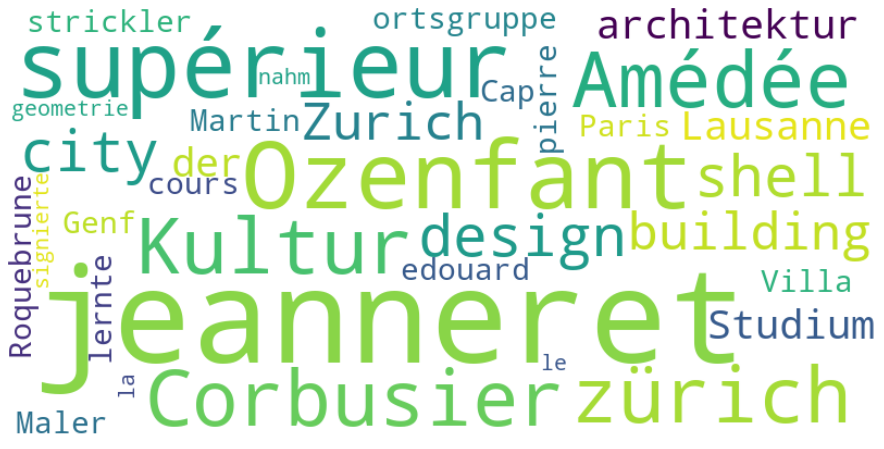

In [21]:
def plot_keywords_word_cloud(keywords1, keywords2, keywords3):
    # Combine all keywords into a single list
    all_keywords = keywords1 + keywords2 + keywords3

# Create a WordCloud
    wc = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(all_keywords))

# Plot the WordCloud
    plt.figure(figsize=(16,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

plot_keywords_word_cloud(keywords_example, keywords_extracted_with_yake_values, keyword_extracted_with_bert)
